In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
df = pd.read_csv('ord_vol.csv')
df['beg_month'] = pd.to_datetime(df['beg_month'])

In [3]:
df.dtypes["ro"] in ['int64', 'datetime64[ns]']

True

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32724 entries, 0 to 32723
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  32724 non-null  int64         
 1   beg_month   32724 non-null  datetime64[ns]
 2   product     32724 non-null  object        
 3   region      32724 non-null  object        
 4   district    32724 non-null  object        
 5   terr        32724 non-null  object        
 6   ro          32724 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 1.7+ MB


In [5]:
df

,Unnamed: 0,beg_month,product,region,district,terr,ro
0,0,2017-01-01,ACUTE,A1,R101,TMV1001,30
1,1,2017-01-01,ACUTE,A1,R101,TMV1002,31
2,2,2017-01-01,ACUTE,A1,R101,TMV1003,24
3,3,2017-01-01,ACUTE,A1,R101,TMV2001,37
4,4,2017-01-01,ACUTE,A1,R102,TMV1007,17
...,...,...,...,...,...,...,...
32719,32719,2021-01-01,HOME,A9,R906,TSV1138,44
32720,32720,2021-01-01,HOME,A9,R906,TSV1142,30
32721,32721,2021-01-01,HOME,A9,R906,TSV1145,48
32722,32722,2021-01-01,HOME,A9,R906,TSV1147,67


In [45]:
# flake8: noqa: E501

import numpy as np
import pandas as pd
import pmdarima
from datetime import datetime
import typing
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

## Changes to be made
## 1 would like to add an argument 

class TSFM(object):
    def __init__(self,
                 df: pd.core.frame.DataFrame,
                 n_pred_period: int,
                 date_variable: typing.Union[int, str],
                 value_variable: typing.Union[int, str],
                 target_variable: str,
                 stop_date: str,         # stop date of train set, to split df to train and test sets
                 section_list: list = None,
                 cycle_length: int = 12,
                 alpha: float = 0.05,):
        self.target_variable = target_variable
        # self.n_pred_period = n_pred_period + abs((datetime.strptime(df[date_variable].to_numpy()[-1])  - datetime.strptime(stop_date, "%Y-%m-%d")).days)
        self.n_pred_period = n_pred_period
        self.stop_date = stop_date
        self.cycle_length = cycle_length
        # train and test df must have date as index, and 2 columns: sections(e.g. territory) and values(e.g. order_volume)
        if type(date_variable) is int:
            date_variable = df.columns[date_variable]
        if type(value_variable) is int:
            value_variable = df.columns[value_variable]
        # Select relevant columns for train and test df, create empty pred df
        self.columns = [date_variable, target_variable, value_variable]
        df[self.columns[0]] = pd.to_datetime(df[self.columns[0]])
        

        self.df = df
        self.pred = pd.DataFrame(columns=self.columns)

        # keys: sections(territories), value: list(train, test, pred), for easy storing and fetching data
        self.df_dict = dict()
        self.model_dict = dict()
        self.adjusted_model_dict = dict()

        # Iterate through the unique sections
        self.section_list = section_list
        if self.section_list is None:
            self.section_list = df[target_variable].unique()
        for section in self.section_list:
            print("Inspecting", section, "...")
            temp_actual_df = self.get_actual_data(section=section, is_adjusted=False)
            if temp_actual_df.shape[0] >= 2 * cycle_length:
                # train actual data
                print("Training", temp_actual_df.shape[0], "actual records ...")
                arima_model = pmdarima.auto_arima(temp_actual_df[temp_actual_df.columns[-1]],
                                                start_p=0, start_P=0,
                                                start_q=0, start_Q=0,
                                                d=1, D=1,
                                                max_p=4, max_P=2,
                                                max_d=2, max_D=2,
                                                max_q=2, max_Q=2,
                                                trace=True, m=cycle_length)
                self.model_dict[section] = arima_model

                temp_adjusted_actual_df = self.get_actual_data(section=section, is_adjusted=True)
                # train adjusted actual data
                print("Training", temp_adjusted_actual_df.shape[0], "adjusted actual records ...")
                arima_model = pmdarima.auto_arima(temp_adjusted_actual_df[temp_adjusted_actual_df.columns[-1]],
                                                start_p=0, start_P=0,
                                                start_q=0, start_Q=0,
                                                d=1, D=1,
                                                max_p=4, max_P=2,
                                                max_d=2, max_D=2,
                                                max_q=2, max_Q=2,
                                                trace=True, m=cycle_length)
                self.adjusted_model_dict[section] = arima_model
            else:
                print("Number of data points in Section", section, "is too small (" + str(
                    temp_actual_df.shape[0]) + ". Must be at least twice the declared cycle length.")

    # DF Getters--------------------------------------------------------------
    def get_actual_data(self, section: str, is_adjusted: bool = True,):
        agg_df = self.df[self.columns].groupby(self.columns[0:2], as_index=False).sum()
        agg_df = agg_df.query(self.columns[1] + "==" + "'" + section + "'")[[self.columns[0], self.columns[2]]]
        agg_df.set_index(self.columns[0], inplace=True)
        agg_df = TSFM.to_monthly(agg_df)
        if is_adjusted:
            return self.anomaly_filter(agg_df)
        return agg_df

    def get_train_data(self, section: str,):  ## added stop date
        actual_df = self.get_actual_data(section)
        return actual_df.iloc[lambda x: x.index <= self.stop_date]

    def get_test_data(self, section: str,):
        actual_df = self.get_actual_data(section)
        return actual_df.iloc[lambda x: x.index > self.stop_date]

    def get_pred_data(self, section: str, return_conf_int: bool = False, is_adjusted: bool = True):
        actual_df = self.get_actual_data(section)
        model = self.get_model(section=section, is_adjusted=is_adjusted)
        print(model.predict(self.n_pred_period, return_conf_int=return_conf_int))
        pred, conf_int = model.predict(self.n_pred_period, return_conf_int=True)
            
        # date_generator = DateGenerator(start_date=max(self.train[self.columns[0]]))
        temp_pred_df = pd.DataFrame(
            data={
                self.columns[0]: pd.date_range(max(actual_df.index),freq='MS',periods=self.n_pred_period+1)[1:],
                self.columns[1]: [section for x in range(len(pred))],
                self.columns[-1]: pred})  # Use numbers inplace of future dates for now)
        self.pred = self.pred.append(temp_pred_df, ignore_index=True)
        temp_pred_df = temp_pred_df[[self.columns[0], self.columns[2]]]
        temp_pred_df.set_index(self.columns[0], inplace=True)
        if return_conf_int:
            return temp_pred_df, conf_int
        return temp_pred_df

    # Model Getters----------------------------------------------------------
    def get_model(self, section: str, is_adjusted: bool = True):
        if is_adjusted:
            return self.adjusted_model_dict[section]
        return self.model_dict[section]
    
    # Plot Function-----------------------------------------------------------
    def plot(self, section: str):
        actual = self.get_actual_data(section, is_adjusted=False)
        adjusted_actual, conf_int_df = self.anomaly_filter(actual, return_conf_int=True)
        # pred, ci = self.get_pred_data(section, return_conf_int=True)

        actual_pred = self.get_pred_data(section, is_adjusted=False)
        adjusted_actual_pred = self.get_pred_data(section, is_adjusted=True)

        fig, ax = plt.subplots(figsize=(14,6))
        ax.plot(actual.index, actual[actual.columns[0]],label="Actual")   #Actuals This should come from original DS (all actuals)
        ax.plot(adjusted_actual.index, adjusted_actual[adjusted_actual.columns[0]],'-g', label="Adjusted Actual")   
        # ax.plot(pred.index, pred[pred.columns[0]], '-r',alpha=0.75,label="Forecast")  ## Pred
        ax.fill_between(conf_int_df.index, conf_int_df.iloc[:, 0], conf_int_df.iloc[:, 1],alpha=0.3, color='b')  ## Conf intervals
        
        ax.plot(actual_pred.index, actual_pred.iloc[:, 0], '--b',alpha=0.75,label="Actual Forecast")
        ax.plot(adjusted_actual_pred.index, adjusted_actual_pred.iloc[:, 0], '--g',alpha=0.75,label="Adjusted Actual Forecast")
        plt.title('Forecast Model')
        plt.xlabel('Year')
        plt.ylabel('Forecast Accurary')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())

        plt.legend()
        plt.show()

    def anomaly_filter(self,
                       df: pd.core.frame.DataFrame,
                       return_conf_int: bool = False, 
                       n_rolling_period: int = 12,
                       alpha: float = 0.05):
        train = df.iloc[lambda x: x.index <= self.stop_date]
        stop_date = max(train.index)
        returning_ic_list = list()
        for i in range(train.shape[0], df.shape[0], 12):
            arima_model = pmdarima.auto_arima(train[train.columns[0]],
                                                start_p=0, start_P=0,
                                                start_q=0, start_Q=0,
                                                d=1, D=1,
                                                max_p=4, max_P=2,
                                                max_d=2, max_D=2,
                                                max_q=2, max_Q=2,
                                                trace=True, m=self.cycle_length)
            temp_actual_df = df.iloc[i:min(i+12, df.shape[0]), :]
            temp_pred, ic_list = arima_model.predict(n_rolling_period, return_conf_int=True, alpha=alpha)
            for j in range(temp_actual_df.shape[0]):
                temp_actual = temp_actual_df.iloc[j, 0]
                ic = ic_list[j]
                if temp_actual < ic[0] or temp_actual > ic[1]:
                    temp_actual_df.iloc[j, 0] = temp_pred[j]
            train = train.append(temp_actual_df)
            returning_ic_list = returning_ic_list + ic_list.tolist()
        if return_conf_int:
            returning_ic_list = np.array(returning_ic_list)
            ic_df = pd.DataFrame(
                data={
                    'lower': returning_ic_list[:, 0],
                    'upper': returning_ic_list[:, 1],
                },
                index=pd.date_range(stop_date,freq='MS',periods=returning_ic_list.shape[0]+1)[1:]
            )
            return train, ic_df
        return train


    @classmethod
    def to_monthly(cls, df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        return df.resample('MS').sum()


In [46]:
tsfm = TSFM(df=df, n_pred_period=24, date_variable='beg_month', target_variable='product', value_variable='ro', stop_date="2020-03-01", section_list=["HOME"])

Inspecting HOME ...
Training 49 actual records ...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=604.245, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=607.707, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=607.531, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=606.084, Time=0.15 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=605.989, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=607.812, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=605.923, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=605.856, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=606.135, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=605.924, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.674 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=412.762, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=415.533, Time=0.

In [47]:
tsfm.get_actual_data("HOME")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=412.762, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=415.533, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=414.340, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=414.748, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=414.762, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=416.718, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=413.543, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=412.348, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=414.340, Time=0.19 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=413.196, Time=0.10 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=412.036, Time=0.12 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=413.947, Time=0.29 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=413.947, Time=0.21 sec
 ARIMA(0,1,2)(1,1,1)[12]             

,ro
beg_month,
2017-01-01,11260.000000
2017-02-01,10906.000000
2017-03-01,12657.000000
2017-04-01,11245.000000
2017-05-01,12505.000000
2017-06-01,13015.000000
2017-07-01,12051.000000
2017-08-01,13442.000000
2017-09-01,12377.000000


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=412.762, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=415.533, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=414.340, Time=0.18 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=414.748, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=414.762, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=416.718, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=413.543, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=412.348, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=414.340, Time=0.21 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=413.196, Time=0.13 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=412.036, Time=0.13 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=413.947, Time=0.29 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=413.947, Time=0.23 sec
 ARIMA(0,1,2)(1,1,1)[12]             

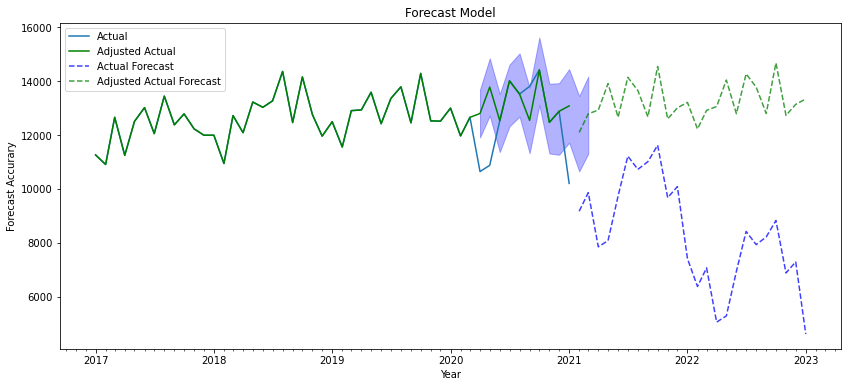

In [49]:
tsfm.plot("HOME")

In [ ]:
df

In [26]:
df.tail()

,Unnamed: 0,beg_month,product,region,district,terr,ro
32720,32720,2021-01-01,HOME,A9,R906,TSV1142,30
32721,32721,2021-01-01,HOME,A9,R906,TSV1145,48
32722,32722,2021-01-01,HOME,A9,R906,TSV1147,67
32723,32723,2021-01-01,HOME,A9,R906,TSV1148,31
32724,32724,2021-12-01,HOME,A7,R707,TSV1103,1


In [27]:
df = df.groupby(['date','prod','region','district','terr']).ro.count().reset_index()
# remove glitch in data
df =  df[df['date'] != df['date'].max()]

KeyError: 'date'

In [31]:
df.query("product == 'HOME'")

,Unnamed: 0,beg_month,product,region,district,terr,ro
461,461,2017-01-01,HOME,A0,R001,TSV1115,22
462,462,2017-01-01,HOME,A0,R001,TSV1196,31
463,463,2017-01-01,HOME,A1,R101,TSV1001,34
464,464,2017-01-01,HOME,A1,R101,TSV1165,85
465,465,2017-01-01,HOME,A1,R101,TSV1173,62
...,...,...,...,...,...,...,...
32720,32720,2021-01-01,HOME,A9,R906,TSV1142,30
32721,32721,2021-01-01,HOME,A9,R906,TSV1145,48
32722,32722,2021-01-01,HOME,A9,R906,TSV1147,67
32723,32723,2021-01-01,HOME,A9,R906,TSV1148,31


In [10]:
df.head(327210)

,Unnamed: 0,beg_month,product,region,district,terr,ro
0,0,2017-01-01,ACUTE,A1,R101,TMV1001,30
1,1,2017-01-01,ACUTE,A1,R101,TMV1002,31
2,2,2017-01-01,ACUTE,A1,R101,TMV1003,24
3,3,2017-01-01,ACUTE,A1,R101,TMV2001,37
4,4,2017-01-01,ACUTE,A1,R102,TMV1007,17
...,...,...,...,...,...,...,...
32719,32719,2021-01-01,HOME,A9,R906,TSV1138,44
32720,32720,2021-01-01,HOME,A9,R906,TSV1142,30
32721,32721,2021-01-01,HOME,A9,R906,TSV1145,48
32722,32722,2021-01-01,HOME,A9,R906,TSV1147,67


In [19]:
df.iloc[12, 1]

Timestamp('2017-01-01 00:00:00')

In [17]:
df.head(14)

,Unnamed: 0,beg_month,product,region,district,terr,ro
0,0,2017-01-01,ACUTE,A1,R101,TMV1001,30
1,1,2017-01-01,ACUTE,A1,R101,TMV1002,31
2,2,2017-01-01,ACUTE,A1,R101,TMV1003,24
3,3,2017-01-01,ACUTE,A1,R101,TMV2001,37
4,4,2017-01-01,ACUTE,A1,R102,TMV1007,17
5,5,2017-01-01,ACUTE,A1,R102,TMV1009,26
6,6,2017-01-01,ACUTE,A1,R102,TMV1010,27
7,7,2017-01-01,ACUTE,A1,R102,TMV2010,8
8,8,2017-01-01,ACUTE,A1,R103,TMV1004,15
9,9,2017-01-01,ACUTE,A1,R103,TMV1020,20
